In [1]:
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('dbUrl')

In [2]:
repos = pd.read_sql_query("select distinct repo_url from repo_tags", con=engine)

In [3]:
%%time
import utils
normalizedCallCounts = []

module = "qs"
function = "parse"

def getNormalizedCallCounts(repo, index):
    engine = create_engine('dbUrl')
    commitHashes = utils.getSortedCommitHashes(repo, engine)
    callCounts = []
    for index, row in commitHashes.iterrows():
        commitHash = row['commit_hash']
        query = """select count(extra->'modules') as count from analyzer_results where commit_hash = %s AND extra->'modules' = '[\"{}\"]' AND extra->>'toFunction' = '{}'""".format(module, function)
        functionCallCount = pd.read_sql_query(query, params=[commitHash], con=engine)
        count = functionCallCount['count'][0] if not functionCallCount.empty else 0
        callCounts.append(count)
        
    print('Progress: {}/{}'.format(index + 1, len(repos)))
    return utils.normalize(callCounts)

def completionFunc(x):
    normalizedCallCounts.append(x.result())

utils.runInParallel(getNormalizedCallCounts, repos, completionFunc)

Progress: 1/100
Progress: 2/100
Progress: 3/100
Progress: 4/100
Progress: 5/100
Progress: 6/100
Progress: 13/100
Progress: 7/100
Progress: 11/100
Progress: 9/100
Progress: 8/100
Progress: 14/100
Progress: 10/100
Progress: 12/100Progress: 15/100

Progress: 18/100
Progress: 19/100
Progress: 16/100
Progress: 20/100
Progress: 26/100
Progress: 54/100
Progress: 17/100
Progress: 56/100
Progress: 60/100
Progress: 59/100
Progress: 65/100
Progress: 64/100
Progress: 62/100
Progress: 61/100
Progress: 63/100
Progress: 24/100
Progress: 68/100
Progress: 69/100
Progress: 78/100
Progress: 28/100
Progress: 86/100
Progress: 87/100
Progress: 85/100
Progress: 30/100
Progress: 29/100
Progress: 31/100
Progress: 88/100
Progress: 32/100
Progress: 89/100
Progress: 100/100
Progress: 99/100
Progress: 90/100
Progress: 98/100
Progress: 35/100
Progress: 36/100
Progress: 38/100
Progress: 37/100
Progress: 39/100
Progress: 41/100
Progress: 43/100
Progress: 45/100
Progress: 46/100
Progress: 48/100Progress: 49/100

Progr

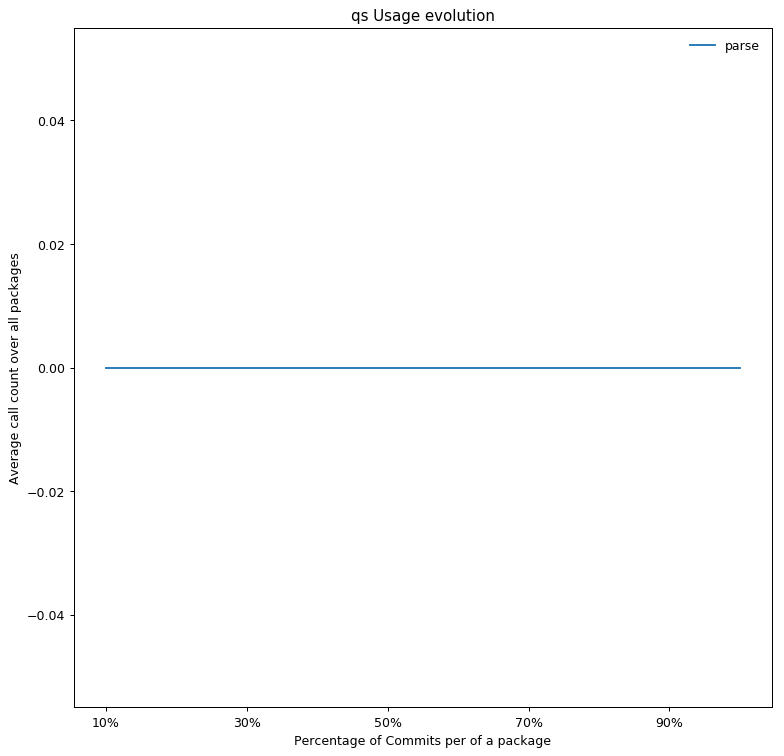

In [5]:
import matplotlib.pyplot as plt
import math
import numpy as np

plt.figure(figsize=(10,10), dpi=90)

totalAverage = []

for x in range(0,10):
    sum = 0
    count = 0
    for arr in normalizedCallCounts:
        if not math.isnan(arr[x]):
            sum = sum + arr[x]
            count = count + 1
    avg = sum / count
    totalAverage.append(avg)
    
plt.plot(np.arange(10), totalAverage, label=function)
plt.xticks([0,2,4,6,8], ['10%', '30%', '50%', '70%', '90%'])
plt.xlabel("Percentage of Commits per of a package")
plt.ylabel('Average call count over all packages')
plt.title("{} Usage evolution".format(module))    
plt.legend(loc='best', frameon=False)


plt.show()